### Import Packages

In [1]:
import requests
import numpy as np
import pandas
from pandas import DataFrame
from pandas import read_csv
from pandas import concat
from collections import Counter
from io import StringIO

from idr import connection
from idr import createHTTPsession
from idr import get_phenotypes_for_gene, attributes_by_attributes
from idr import get_entrezid, get_ensembleid, genes_of_interest_fromGO

### Variables

In [3]:
GO_TERM = 'GO:0016459' #myosin complex

### Get gene list from Gene Ontology (QuickGO)

In [25]:
goGenelist = list(set(genes_of_interest_fromGO(GO_TERM)) - set(['Symbol', '-']))
print goGenelist

['MYH10', 'MYH11', 'MYOM1', 'MYH13', 'MYH14', 'MYH15', 'ACTG2', 'DYNLL2', 'MYO1F', 'SHROOM4', 'MYO1C', 'MYO6', 'MYL6', 'MYO18B', 'MYL5', 'MYL3', 'MYL1', 'MYL9', 'MYH2', 'MYH3', 'MYH1', 'MYH6', 'MYBPH', 'MYH4', 'MYBPHL', 'MYH9', 'MYOM3', 'TTN', 'OBSL1', 'TRIM32', 'MYBPC1', 'MYOM2', 'IGSF22', 'MYH7', 'MYH7B', 'MYL12B', 'SHROOM1', 'MYBPC3', 'MYBPC2', 'MYO9A', 'MYO5A', 'MYL6B', 'MYO7A', 'MYH8', 'MYLPF']


### Check distribution of phenotypes vertically in the IDR for the subset of genes 

In [5]:
from ipywidgets import FloatProgress
from IPython.display import display, HTML

testedgenes = [] 

f = FloatProgress(min=0, max=len(goGenelist))
display(f)

df = {}
totalPhenotypeName = []
totalPhenotypeAccession = []

phenotypeNameToAcc = {}
for gene in goGenelist:
    
    if gene.startswith("-"):
        continue
    entrezid = get_entrezid(gene)
    ensembleid = get_ensembleid(gene)
    f.value += 1 
    gid = None
    # search with the gene name
    uniqueList = []
    if len(uniqueList) == 0:
        key = "GeneName"
        gid = gene
        uniqueList = get_phenotypes_for_gene(gid)
    
    # search with ensembleid if geneSymbol does not return any result
    if len(uniqueList['Name']) == 0:
        key = "EnsemblID"
        for gid in ensembleid:
            uniqueList = get_phenotypes_for_gene(gid)
            if len(uniqueList['Name']) != 0:
                break
            
    # search with entrezid if gene symbol and ensembleid does not return any result 
    if len(uniqueList) == 0:
        key = "EntrezID"
        for gid in entrezid:
            uniqueList = get_phenotypes_for_gene(gid)
            if len(uniqueList['Name']) != 0:
                break
                
    # List of genes from string which were part of IDR
    if gid != None:
        testedgenes.append(gid)
        
    # Dataframe of genes from string which were part of IDR and had a phenotype associated with them
    if len(uniqueList) != 0:

        accname = uniqueList['Name']
        accid = uniqueList['Accession']
        
        accnames = list(accname.values)
        accids = list(accid.values)
        
        for idx,idx1 in enumerate(accnames):
            phenotypeNameToAcc[accnames[idx]] = accids[idx]     
        
        totalPhenotypeName = totalPhenotypeName + accnames
        totalPhenotypeAccession = totalPhenotypeAccession + accids
        
        df[gene] = [entrezid, ensembleid, None, None, None, None]
        df[gene][2] = key
        df[gene][3] = gid
        df[gene][4] = accnames
        df[gene][5] = accids
        genes = pandas.DataFrame.from_dict(df, orient='index')
        genes.columns = ("Entrez", "Ensembl", "Key", "Value", "PhenotypeName", "PhenotypeAccession")

display(HTML(genes.to_html( escape=False)))

,Entrez,Ensembl,Key,Value,PhenotypeName,PhenotypeAccession
MYH10,[4628],[ENSG00000133026],GeneName,MYH10,[strong decrease in rate of protein secretion],[CMPO_0000319]
MYOM2,[9172],"[ENSG00000036448, ENSG00000274137]",GeneName,MYOM2,"[strong decrease in rate of protein secretion,...","[CMPO_0000318, CMPO_0000319, CMPO_0000319]"
MYH15,[22989],[ENSG00000144821],GeneName,MYH15,"[decreased cell numbers, elongated cell phenot...","[CMPO_0000270, CMPO_0000294, CMPO_0000288, CMP..."
ACTG2,[72],[ENSG00000163017],GeneName,ACTG2,[mild decrease in rate of protein secretion],[CMPO_0000318]
DYNLL2,[140735],[ENSG00000264364],GeneName,DYNLL2,[mild decrease in rate of protein secretion],[CMPO_0000318]
MYO1F,[4542],[ENSG00000142347],GeneName,MYO1F,"[decreased cell numbers, elongated cell phenot...","[CMPO_0000272, CMPO_0000288, CMPO_0000263, CMP..."
MYO1C,[4641],"[ENSG00000157483, ENSG00000197879]",EnsemblID,ENSG00000157483,[mild decrease in rate of protein secretion],[CMPO_0000318]
SHROOM1,[134549],[ENSG00000164403],GeneName,SHROOM1,[increased variability of nuclear shape in pop...,[CMPO_0000345]
MYL5,[4636],[ENSG00000215375],GeneName,MYL5,"[increased cell movement distance, increased c...","[CMPO_0000237, CMPO_0000236]"
MYL1,[4632],[ENSG00000168530],GeneName,MYL1,[strong decrease in rate of protein secretion],[CMPO_0000319]


### Gene list per phenotype (per screen) for the subset of phenotypes listed by the proteasome complex:

In [8]:
from idr import connection
conn = connection()
IDR_BASE_URL = "http://idr.openmicroscopy.org"
SCREENS_PROJECTS_URL = "{base}/mapr/api/{key}/?value={value}"
try:
    querygenes = []    
    
    for index, gene in genes.iterrows():
        querygenes.append(gene['Value'])
    
    screenidList = []
    screennameList = []
    phenotypeList = {}
    
    session = createHTTPsession()
    for idx1,phenotype in enumerate(np.unique(totalPhenotypeName)):
        
        qs = {'base': IDR_BASE_URL, 'key': 'phenotype', 'value': phenotypeNameToAcc[phenotype]}
        url = SCREENS_PROJECTS_URL.format(**qs)
                
        for s in session.get(url).json()['screens']:
            screenidList.append(s['id'])
            screennameList.append(s['name'] + ' : ' + phenotype)
    
    f = FloatProgress(min=0, max=len(np.unique(totalPhenotypeName))*len(set(screenidList)))
    display(f)

    intersectingQueryGenes = {}   
    phenotypeSpecificGenes = {}
    for idx2,sid in enumerate(set(screenidList)):
        
        for idx1,phenotype in enumerate(np.unique(totalPhenotypeName)):
            
            args = {
                "name": "Phenotype Term Name",
                "value": phenotype,
                "ns": "openmicroscopy.org/mapr/phenotype",
                "ns2": "openmicroscopy.org/mapr/gene",
                "sId": sid
            }
            
            cc = attributes_by_attributes(conn, **args)
            dataframe = pandas.DataFrame.from_dict(cc)
            f.value += 1 
            
            if dataframe.empty:
                continue
                
            idList = []
            for x in dataframe.ix[:,0]:

                key = x[0]
                value = x[1]

                if key == "Gene Identifier" and value.startswith("EN"):
                    id = value
                    idList.append(id)
                if key == "Gene Symbol":
                    geneSym = value
                    idList.append(geneSym)        
            
            key = 'screenId : ' + str(sid) + ' : ' + phenotype
            overlapGenes = set(idList).intersection(querygenes)
            if len(overlapGenes) != 0:
                intersectingQueryGenes[key] = [overlapGenes]
                setdiffGenes = set(idList) - overlapGenes
                phenotypeList[key] = list(setdiffGenes)
    
    phenotypeSpecificGenes = pandas.DataFrame.from_dict(phenotypeList, orient='index')
    genesTotal = pandas.DataFrame.from_dict(intersectingQueryGenes, orient='index')
    display(HTML(genesTotal.to_html(escape=False)))        
finally:
    conn.close()                    

Connected to IDR...


/Users/bramalingam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,0
screenId : 1101 : increased cell movement distance,"{MYH9, MYL5}"
screenId : 206 : fan-shaped lamellipodia phenotype,"{MYH9, MYH7, MYH4}"
screenId : 1652 : increased level of polypetide in cell nucleus,{MYO9A}
screenId : 1302 : abnormal nucleus shape phenotype,{MYL6B}
screenId : 1653 : decreased level of polypetide in cell nucleus,{MYO9A}
screenId : 803 : strong decrease in rate of protein secretion,{MYOM2}
screenId : 206 : microtubules nuclear ring phenotype,"{MYO1F, MYH15}"
screenId : 1801 : decreased cell size phenotype,{MYO9A}
screenId : 1651 : decreased level of polypetide in cell nucleus,{MYO9A}
screenId : 206 : increased variability of cell size in population,"{MYH15, MYH4}"


### Plot number of phenotypes per query gene  in IDR

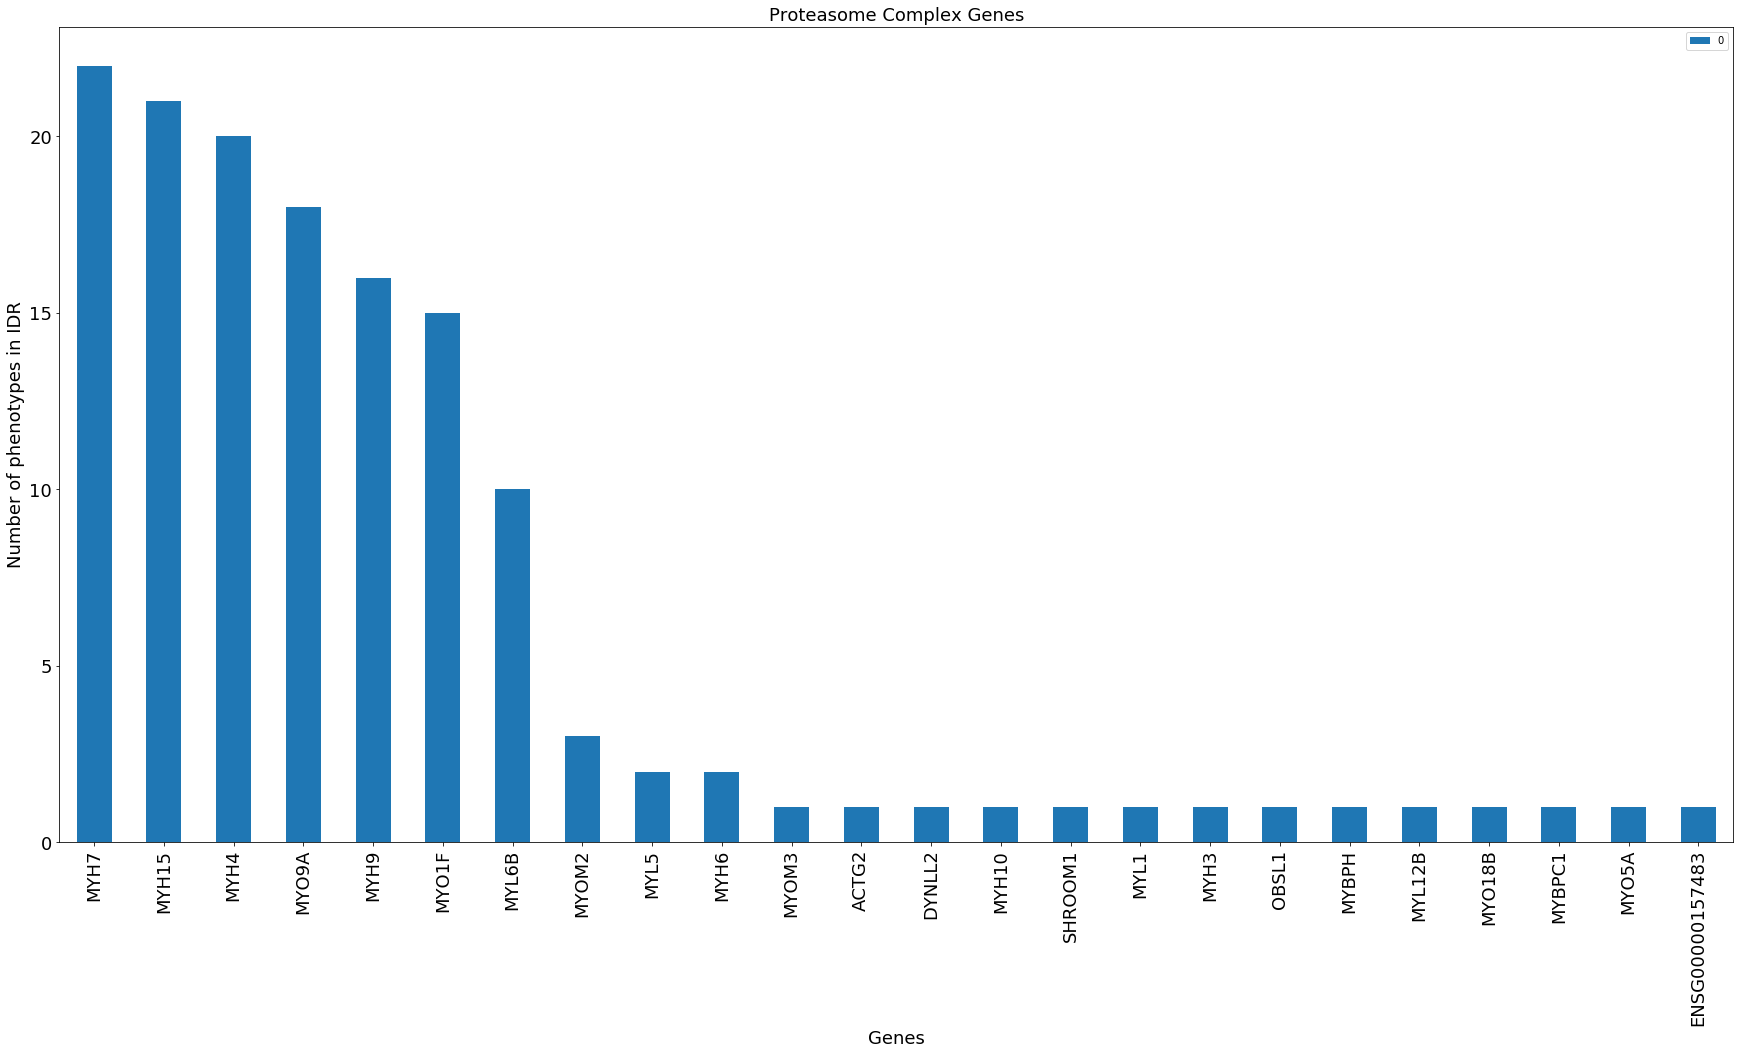

In [22]:
# import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
geneCounts = []    
for index, gene in genesTotal.iterrows():
    geneCounts = geneCounts + list(gene[0])
letter_counts = Counter(geneCounts)

df = pandas.DataFrame.from_dict(OrderedDict(letter_counts.most_common()), orient='index')
ax = df.plot(kind='bar',figsize=(30, 15), fontsize=18)
ax.set_title("Proteasome Complex Genes", fontsize=18)
ax.set_xlabel("Genes", fontsize=18)
ax.set_ylabel("Number of phenotypes in IDR", fontsize=18)
# pandas.tseries.plotting.pylab.show()

### Extract potentially similar genes in IDR within the phenotypes listed in the table

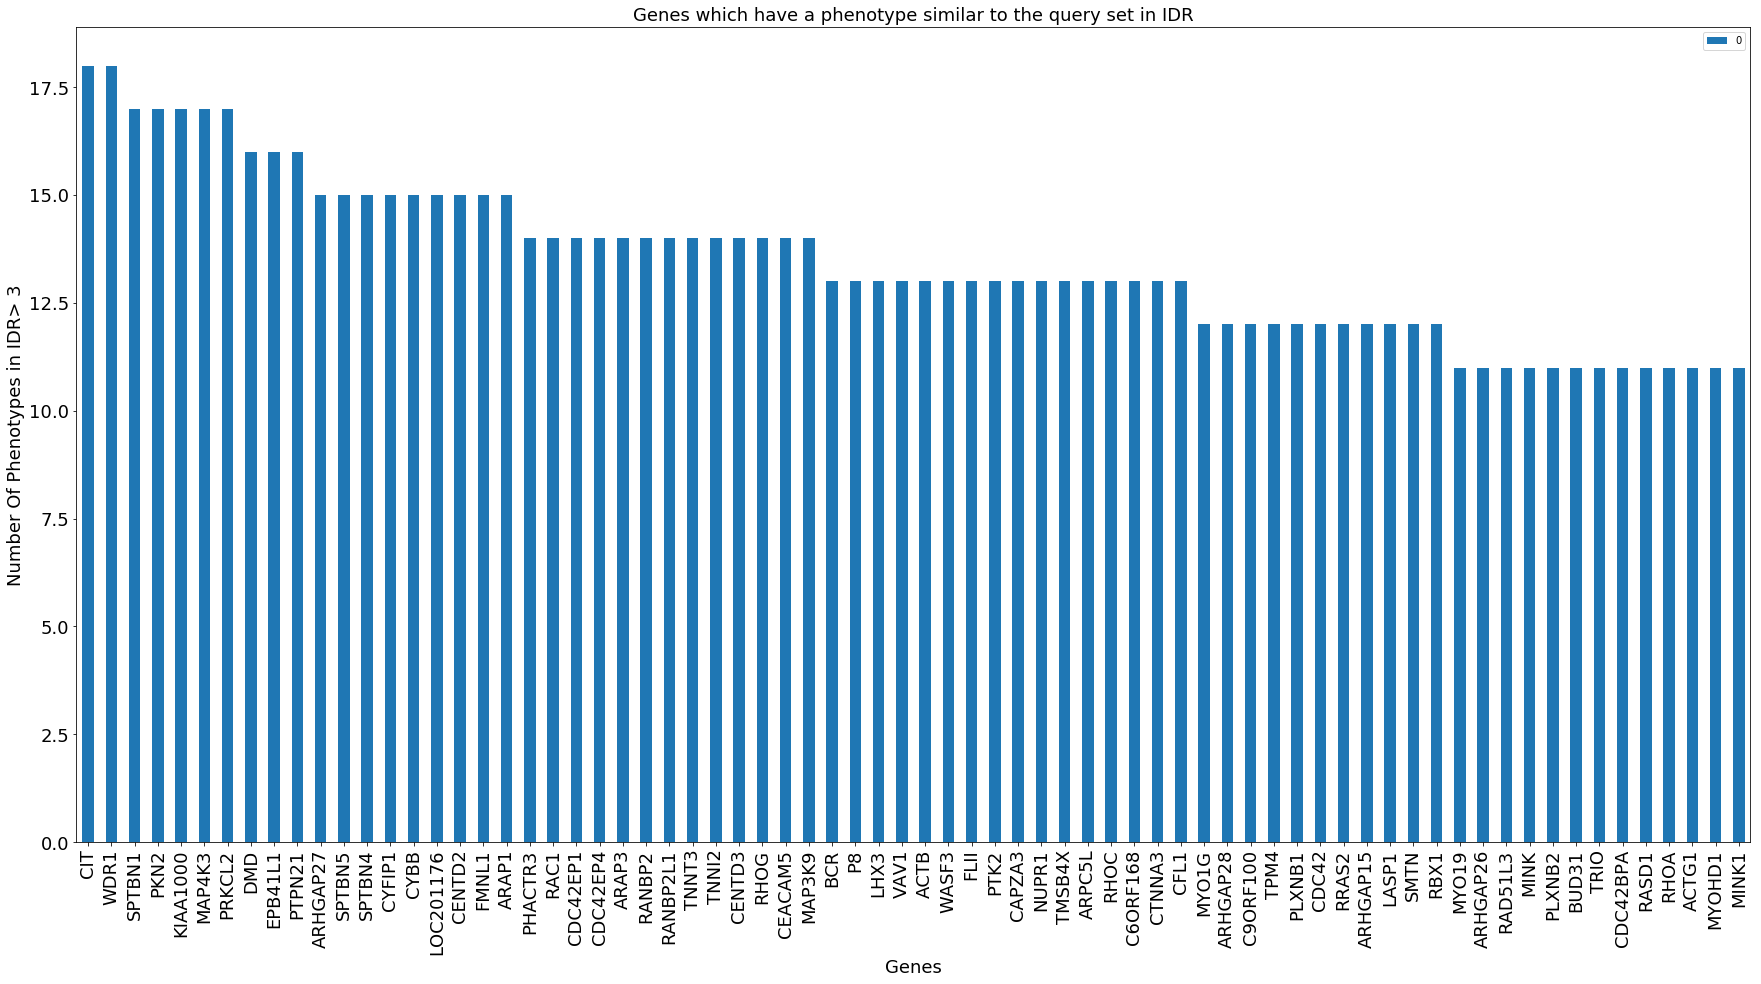

In [24]:
def convertEnsembleToGeneSymbol(ensembleId):
    
    ensembleserver = "http://rest.ensembl.org/xrefs/id/"
    url = ensembleserver + ensembleId + "?content-type=application/json;external_db=WikiGene"
    
    res = requests.get(url)

    if "error" in res.text:
        return ensembleId
    
    results = pandas.read_json(StringIO(res.text))
    if results.empty:
        return ensembleId
    
    symbol = results['display_id'][0]
    
    return symbol

geneCounts = []   
for phenotype in list(phenotypeList.keys()):

    ovlapgenes = intersectingQueryGenes[phenotype]

    if len(list(ovlapgenes[0])) >= 2:
        genes = phenotypeList[phenotype]   
        geneCounts.extend(genes)

letter_counts = Counter(geneCounts)
letter_counts = OrderedDict(letter_counts.most_common())

dict1 = OrderedDict()

for k,v in letter_counts.iteritems():
    if v > 10:
        key = k
        if k.startswith('ENSG'):
            key = convertEnsembleToGeneSymbol(k)
            if key in dict1:
                value1 = dict1[key]
                if value1 > v:
                    v = value1               
        dict1[key] = v
if '' in dict1:
    del dict1['']
df = pandas.DataFrame.from_dict(dict1, orient='index')
ax = df.plot(kind='bar', figsize=(30, 15), fontsize=18) 
ax.set_title("Genes which have a phenotype similar to the query set in IDR", fontsize=18)
ax.set_xlabel("Genes", fontsize=18)
ax.set_ylabel("Number Of Phenotypes in IDR> 3", fontsize=18)